(50000, 21)
(1027, 20)
(10000, 14)
Missing values in flood_factors: 0
Missing values in flood_events: 9854
Missing values in flood_risk: 0


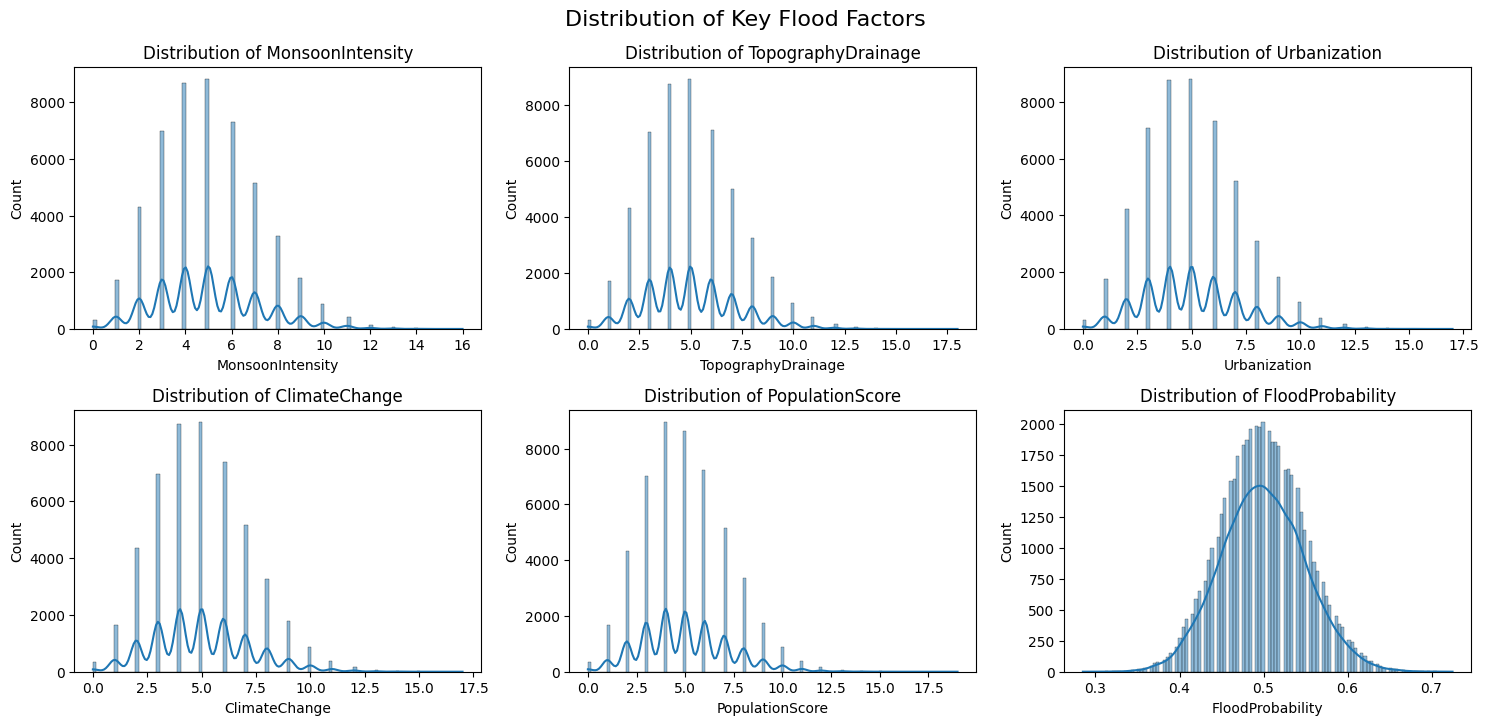

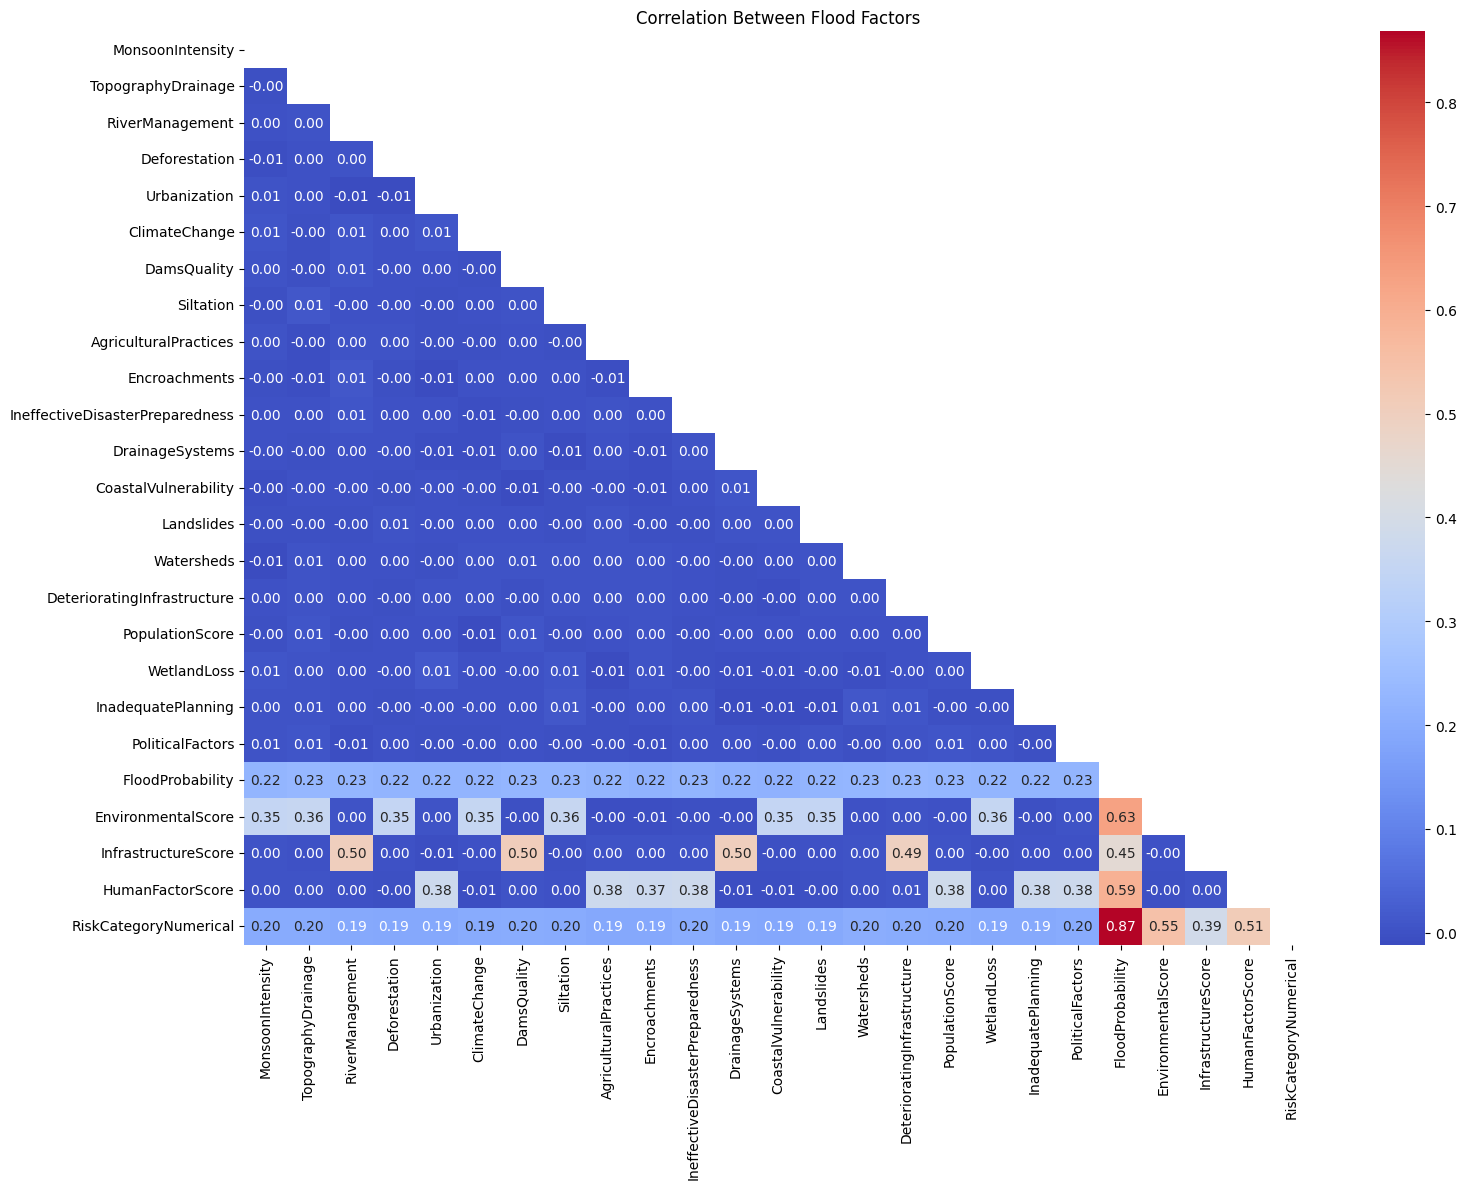

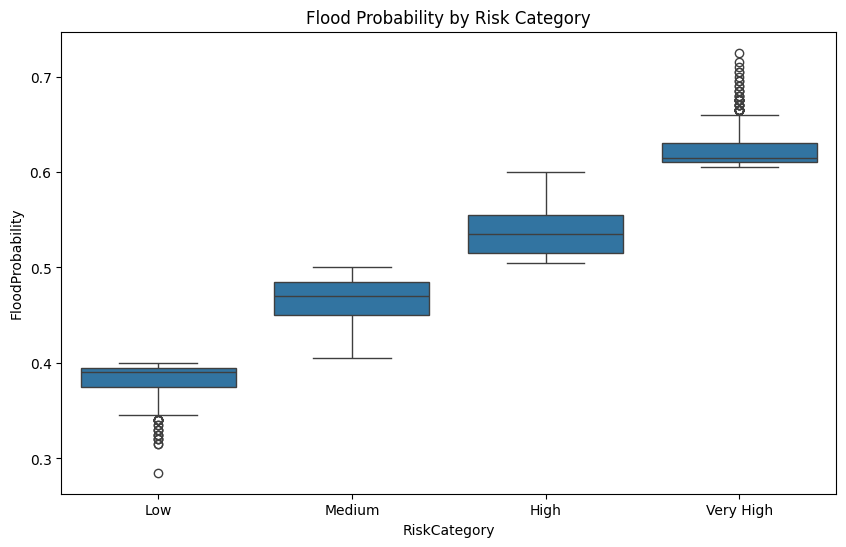

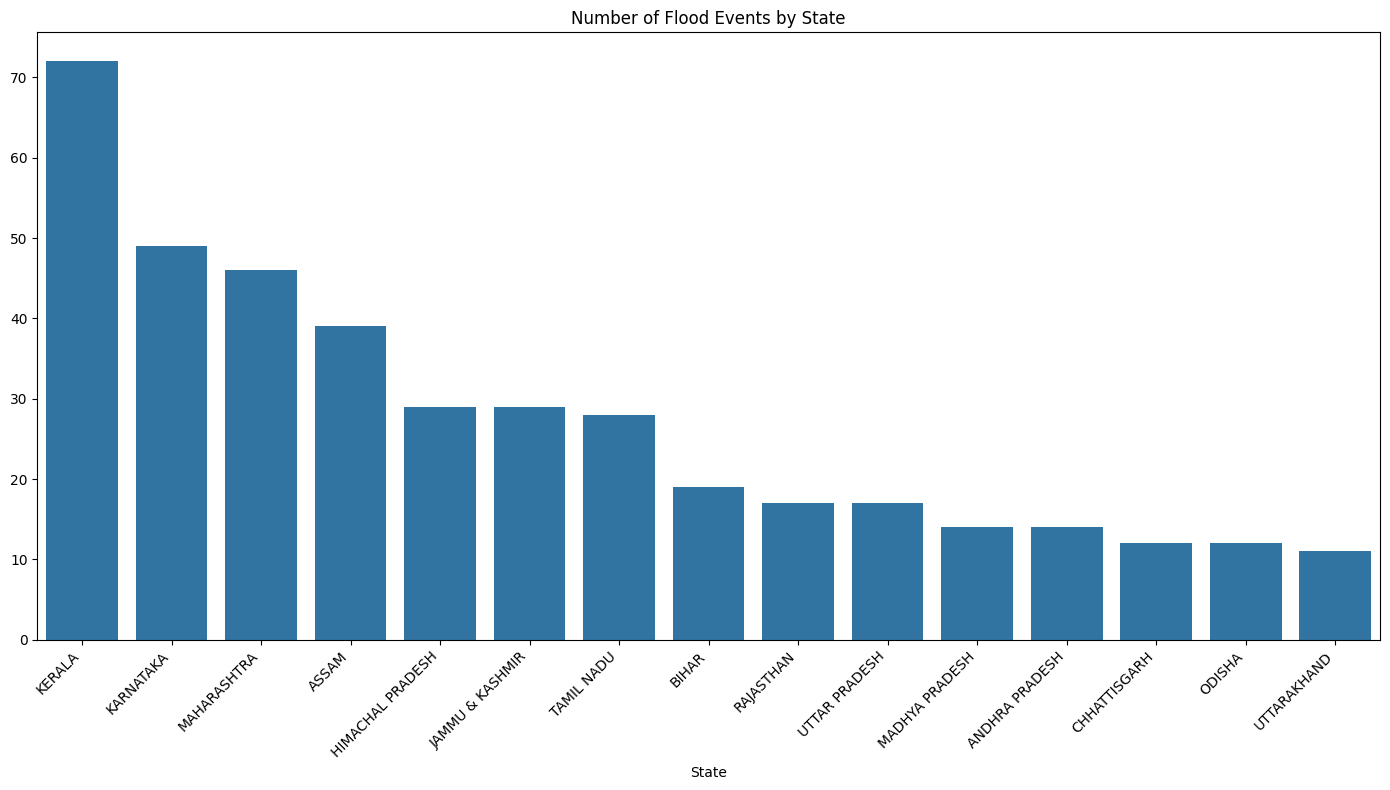

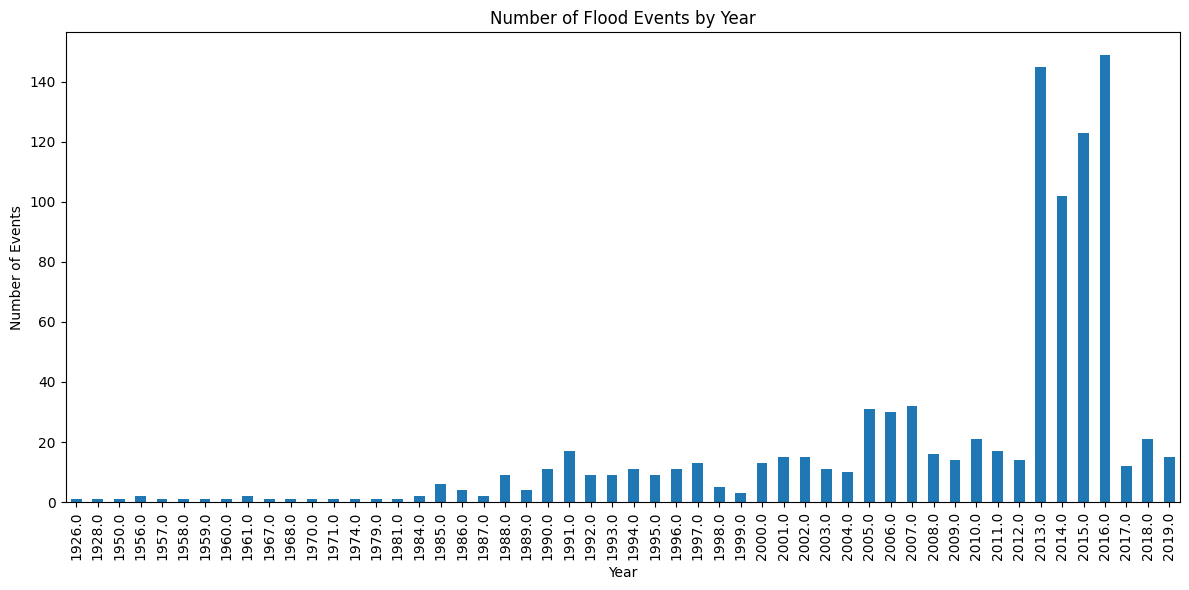

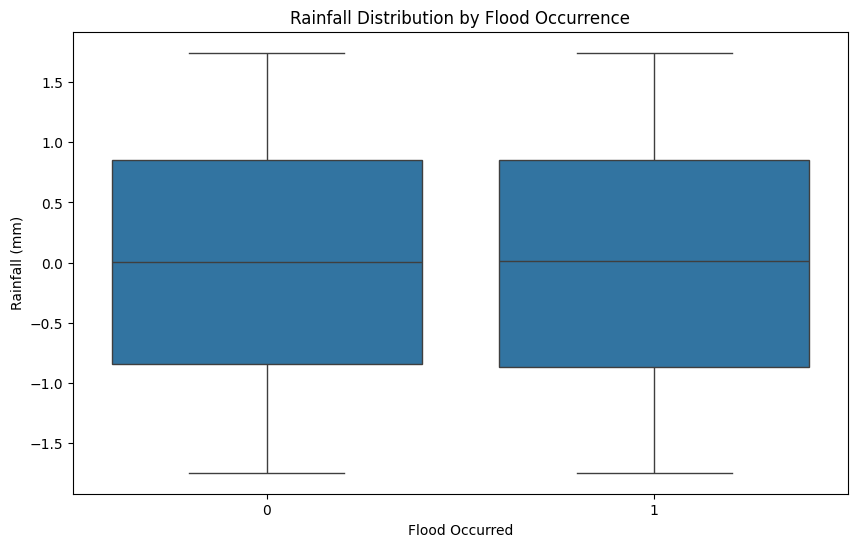

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

# Load the datasets
flood_factors = pd.read_csv('./datasets/floods_factors/flood.csv')
flood_events = pd.read_csv('./datasets/floods_inventory/India_Floods_Inventory.csv')
flood_risk = pd.read_csv('./datasets/india_flood_risk/flood_risk_dataset_india.csv')

# Display basic information about the datasets
print(flood_factors.shape)
print(flood_events.shape)
print(flood_risk.shape)

# Check for missing values
print("Missing values in flood_factors:", flood_factors.isnull().sum().sum())
print("Missing values in flood_events:", flood_events.isnull().sum().sum())
print("Missing values in flood_risk:", flood_risk.isnull().sum().sum())

# Handle missing values in flood_events
flood_events_clean = flood_events.copy()

# Convert date columns to datetime
flood_events_clean['Start Date'] = pd.to_datetime(flood_events_clean['Start Date'], errors='coerce')
flood_events_clean['End Date'] = pd.to_datetime(flood_events_clean['End Date'], errors='coerce')

# Calculate duration properly
flood_events_clean['Duration'] = (flood_events_clean['End Date'] - flood_events_clean['Start Date']).dt.days

# Fill missing numerical values with median
numerical_cols = ['Latitude', 'Longitude', 'Severity', 'Area Affected',
                 'Human fatality', 'Human injured', 'Human Displaced', 'Animal Fatality']
imputer = SimpleImputer(strategy='median')
flood_events_clean[numerical_cols] = imputer.fit_transform(flood_events_clean[numerical_cols])

# Group flood events by state and calculate statistics
state_flood_stats = flood_events_clean.groupby('State').agg({
    'Human fatality': 'sum',
    'Human Displaced': 'sum',
    'Duration': 'mean',
    'UEI': 'count'  # Count of flood events
}).reset_index()
state_flood_stats.rename(columns={'UEI': 'FloodEventCount'}, inplace=True)

# Process the flood risk dataset
# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Rainfall (mm)', 'Temperature (°C)', 'Humidity (%)',
                      'River Discharge (m³/s)', 'Water Level (m)', 'Elevation (m)',
                      'Population Density']
flood_risk[numerical_features] = scaler.fit_transform(flood_risk[numerical_features])

# One-hot encode categorical features
categorical_features = ['Land Cover', 'Soil Type']
flood_risk_encoded = pd.get_dummies(flood_risk, columns=categorical_features)

# Feature engineering for flood factors dataset
# Calculate average score for each category
flood_factors['EnvironmentalScore'] = flood_factors[['MonsoonIntensity', 'TopographyDrainage',
                                                   'Deforestation', 'ClimateChange',
                                                   'Siltation', 'CoastalVulnerability',
                                                   'Landslides', 'WetlandLoss']].mean(axis=1)

flood_factors['InfrastructureScore'] = flood_factors[['RiverManagement', 'DamsQuality',
                                                    'DrainageSystems', 'DeterioratingInfrastructure']].mean(axis=1)

flood_factors['HumanFactorScore'] = flood_factors[['Urbanization', 'AgriculturalPractices',
                                                 'Encroachments', 'IneffectiveDisasterPreparedness',
                                                 'PopulationScore', 'InadequatePlanning',
                                                 'PoliticalFactors']].mean(axis=1)

# Create a risk category based on FloodProbability
flood_factors['RiskCategory'] = pd.cut(flood_factors['FloodProbability'],
                                     bins=[0, 0.4, 0.5, 0.6, 1.0],
                                     labels=['Low', 'Medium', 'High', 'Very High'])

# Convert RiskCategory to numerical representation using .cat.codes
flood_factors['RiskCategoryNumerical'] = flood_factors['RiskCategory'].cat.codes

# Create a function to plot distribution of features
def plot_feature_distributions(df, features, title):
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features):
        plt.subplot(3, 3, i+1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

# Plot distribution of key features in flood_factors
key_features = ['MonsoonIntensity', 'TopographyDrainage', 'Urbanization',
                'ClimateChange', 'PopulationScore', 'FloodProbability']
plot_feature_distributions(flood_factors, key_features, 'Distribution of Key Flood Factors')

# Correlation heatmap for flood factors
plt.figure(figsize=(16, 12))
correlation = flood_factors.corr(numeric_only=True) # Corrected line
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Between Flood Factors')
plt.tight_layout()
plt.show()

# Plot flood probability by risk category
plt.figure(figsize=(10, 6))
sns.boxplot(x='RiskCategory', y='FloodProbability', data=flood_factors)
plt.title('Flood Probability by Risk Category')
plt.show()

# Analyze flood events by state
plt.figure(figsize=(14, 8))
state_events = flood_events_clean['State'].value_counts().sort_values(ascending=False).head(15)
sns.barplot(x=state_events.index, y=state_events.values)
plt.title('Number of Flood Events by State')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze temporal patterns of flood events
flood_events_clean['Year'] = flood_events_clean['Start Date'].dt.year
yearly_events = flood_events_clean.groupby('Year').size()
plt.figure(figsize=(12, 6))
yearly_events.plot(kind='bar')
plt.title('Number of Flood Events by Year')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.tight_layout()
plt.show()

# Analyze relationship between rainfall and flood occurrence in flood_risk dataset
plt.figure(figsize=(10, 6))
sns.boxplot(x='Flood Occurred', y='Rainfall (mm)', data=flood_risk)
plt.title('Rainfall Distribution by Flood Occurrence')
plt.show()


In [20]:
import rasterio
import os
import numpy as np
from glob import glob
import gc  # Garbage collector
from rasterio.windows import Window

# Path to your TIF files
tif_files = glob('./datasets/satellite_imagery/*.tif')

# Function to preprocess each image in chunks
def preprocess_satellite_image(tif_path, chunk_size=1000, sample_rate=10):
    with rasterio.open(tif_path) as src:
        # Get image dimensions
        bands = src.count
        height = src.height
        width = src.width
        
        # Calculate number of chunks
        n_chunks_y = (height + chunk_size - 1) // chunk_size
        n_chunks_x = (width + chunk_size - 1) // chunk_size
        
        # Determine reduced dimensions based on sampling rate
        reduced_height = height // sample_rate
        reduced_width = width // sample_rate
        
        # Initialize downsampled image
        downsampled = np.zeros((bands, reduced_height, reduced_width), dtype=np.float32)
        
        # Process the image in chunks
        for y_chunk in range(n_chunks_y):
            for x_chunk in range(n_chunks_x):
                # Define the window
                y_offset = y_chunk * chunk_size
                x_offset = x_chunk * chunk_size
                y_size = min(chunk_size, height - y_offset)
                x_size = min(chunk_size, width - x_offset)
                
                # Read the chunk
                window = Window(x_offset, y_offset, x_size, y_size)
                chunk = src.read(window=window)
                
                # Downsample the chunk (simple strided sampling)
                if sample_rate > 1:
                    y_start, y_end = y_offset // sample_rate, min((y_offset + y_size) // sample_rate, reduced_height)
                    x_start, x_end = x_offset // sample_rate, min((x_offset + x_size) // sample_rate, reduced_width)
                    
                    # Skip chunks that are completely outside the downsampled area
                    if y_start >= y_end or x_start >= x_end:
                        continue
                    
                    # Sample pixels from the chunk
                    for b in range(bands):
                        for y_rel in range(0, y_size, sample_rate):
                            y_ds = (y_offset + y_rel) // sample_rate
                            if y_ds >= reduced_height:
                                break
                                
                            for x_rel in range(0, x_size, sample_rate):
                                x_ds = (x_offset + x_rel) // sample_rate
                                if x_ds >= reduced_width:
                                    break
                                
                                if y_rel < chunk.shape[1] and x_rel < chunk.shape[2]:
                                    downsampled[b, y_ds, x_ds] = chunk[b, y_rel, x_rel]
        
        # Normalize the downsampled image
        for b in range(bands):
            band_data = downsampled[b]
            min_val = np.min(band_data)
            max_val = np.max(band_data)
            if max_val > min_val:
                downsampled[b] = (band_data - min_val) / (max_val - min_val)
        
        # Get metadata
        metadata = {
            'driver': src.driver,
            'width': width,
            'height': height,
            'count': bands,
            'dtype': src.dtypes[0],
            'crs': src.crs,
            'transform': src.transform,
            'original_shape': (bands, height, width),
            'downsampled_shape': downsampled.shape,
            'sample_rate': sample_rate
        }
        
        return downsampled, metadata, os.path.basename(tif_path)

# Alternative approach: Extract features from each image without loading the entire image
def extract_image_features(tif_path, num_samples=1000):
    with rasterio.open(tif_path) as src:
        bands = src.count
        height = src.height
        width = src.width
        
        # Randomly sample pixels
        np.random.seed(42)  # For reproducibility
        y_samples = np.random.randint(0, height, num_samples)
        x_samples = np.random.randint(0, width, num_samples)
        
        # Extract sample values
        band_stats = []
        for b in range(1, bands + 1):  # Rasterio band indices start from 1
            band_values = [src.read(b, window=Window(x, y, 1, 1))[0, 0] for x, y in zip(x_samples, y_samples)]
            
            # Calculate statistics
            band_mean = np.mean(band_values)
            band_std = np.std(band_values)
            band_min = np.min(band_values)
            band_max = np.max(band_values)
            band_median = np.median(band_values)
            band_q1 = np.percentile(band_values, 25)
            band_q3 = np.percentile(band_values, 75)
            
            band_stats.extend([band_mean, band_std, band_min, band_max, band_median, band_q1, band_q3])
        
        # Extract band ratios for common indices (for multispectral data)
        # Example: NDVI (if bands 4=NIR and 3=Red are present)
        band_ratios = []
        if bands >= 4:
            try:
                # Sample for NIR (usually band 4) and Red (usually band 3)
                nir_samples = [src.read(4, window=Window(x, y, 1, 1))[0, 0] for x, y in zip(x_samples, y_samples)]
                red_samples = [src.read(3, window=Window(x, y, 1, 1))[0, 0] for x, y in zip(x_samples, y_samples)]
                
                # Calculate NDVI for each sample
                ndvi_values = []
                for nir, red in zip(nir_samples, red_samples):
                    if nir + red == 0:
                        ndvi_values.append(0)
                    else:
                        ndvi_values.append((nir - red) / (nir + red))
                
                # Add NDVI statistics
                ndvi_mean = np.mean(ndvi_values)
                ndvi_std = np.std(ndvi_values)
                band_ratios.extend([ndvi_mean, ndvi_std])
            except:
                # Handle case where bands don't match expected pattern
                band_ratios.extend([0, 0])
        
        # Get metadata
        metadata = {
            'driver': src.driver,
            'width': width,
            'height': height,
            'count': bands,
            'dtype': src.dtypes[0],
            'crs': src.crs,
            'transform': src.transform
        }
        
        # Combine all features
        features = np.array(band_stats + band_ratios)
        
        return features, metadata, os.path.basename(tif_path)

# Process all images using the memory-efficient approach
processed_images = []
for tif_file in tif_files:
    try:
        # Choose one of these approaches based on your needs
        # Option 1: Downsample the entire image
        image, metadata, filename = preprocess_satellite_image(tif_file, chunk_size=1000, sample_rate=20)
        
        # Option 2: Extract statistical features only
        # features, metadata, filename = extract_image_features(tif_file)
        
        processed_images.append({
            'image': image,  # Or 'features' if using Option 2
            'metadata': metadata,
            'filename': filename
        })
        
        # Force garbage collection
        gc.collect()
        
        print(f"Processed {filename} successfully")
    except Exception as e:
        print(f"Error processing {tif_file}: {str(e)}")

Processed Sentinel2_Flood_11_22.9061_88.0848.tif successfully
Processed Sentinel2_Flood_16_33.3752_75.1439.tif successfully
Processed Sentinel2_Flood_18_19.5656_74.5501.tif successfully
Processed Sentinel2_Flood_20_9.39943_76.7275.tif successfully
Processed Sentinel2_Flood_21_27.2914_94.1222.tif successfully
Processed Sentinel2_Flood_22_25.7354_82.4309.tif successfully
Processed Sentinel2_Flood_25_17.9_83.3588.tif successfully
Processed Sentinel2_Flood_26_21.5427_87.4662.tif successfully
Processed Sentinel2_Flood_29_20.2969_74.748.tif successfully
Processed Sentinel2_Flood_30_11.4575_76.0842.tif successfully
Processed Sentinel2_Flood_31_19.1145_83.4825.tif successfully
Processed Sentinel2_Flood_32_25.3928_74.3521.tif successfully
Processed Sentinel2_Flood_42_10.489_79.004.tif successfully
Processed Sentinel2_Flood_4_27.068_93.949.tif successfully
Processed Sentinel2_Flood_6_21.7477_73.4119.tif successfully
Processed Sentinel2_Flood_7_25.6099_85.1898.tif successfully
Processed Sentinel2

In [22]:
import rasterio
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import block_reduce

def extract_texture_features(tif_path, sample_size=500):
    with rasterio.open(tif_path) as src:
        # Get a representative region from the center of the image
        center_y, center_x = src.height // 2, src.width // 2
        half_sample = sample_size // 2
        
        # Define the window
        window = rasterio.windows.Window(
            center_x - half_sample, 
            center_y - half_sample,
            sample_size, 
            sample_size
        )
        
        # Read the center region (use first band for texture analysis)
        band_idx = 1  # First band
        sample = src.read(band_idx, window=window)
        
        # Rescale to 8-bit for GLCM calculation
        if sample.min() != sample.max():  # Avoid division by zero
            sample_8bit = ((sample - sample.min()) / (sample.max() - sample.min()) * 255).astype(np.uint8)
        else:
            sample_8bit = np.zeros_like(sample, dtype=np.uint8)
        
        # Calculate texture features (GLCM)
        distances = [1, 3, 5]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        
        try:
            glcm = graycomatrix(sample_8bit, distances=distances, angles=angles, 
                               levels=256, symmetric=True, normed=True)
                               
            # Calculate properties
            contrast = graycoprops(glcm, 'contrast').flatten()
            dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
            homogeneity = graycoprops(glcm, 'homogeneity').flatten()
            energy = graycoprops(glcm, 'energy').flatten()
            correlation = graycoprops(glcm, 'correlation').flatten()
            
            # Multi-scale analysis - downsample and compute statistics
            downsampled = block_reduce(sample, block_size=(4, 4), func=np.mean)
            
            # Basic statistics of the region
            region_mean = np.mean(sample)
            region_std = np.std(sample)
            region_min = np.min(sample)
            region_max = np.max(sample)
            
            # Combine all features
            texture_features = np.concatenate([
                contrast, dissimilarity, homogeneity, energy, correlation,
                [region_mean, region_std, region_min, region_max]
            ])
            
            # Get some metadata
            metadata = {
                'driver': src.driver,
                'crs': src.crs,
                'transform': src.transform,
                'window': {
                    'x': center_x - half_sample,
                    'y': center_y - half_sample,
                    'width': sample_size,
                    'height': sample_size
                }
            }
            
            return texture_features, metadata, os.path.basename(tif_path)
            
        except Exception as e:
            print(f"Error calculating texture features: {str(e)}")
            # Return basic stats if GLCM fails
            return np.array([np.mean(sample), np.std(sample)]), {}, os.path.basename(tif_path)

In [31]:
import pickle

# Save extracted features
with open("processed_satellite_features.pkl", "wb") as f:
    pickle.dump(processed_images, f)

print("Satellite image features saved successfully!")


Satellite image features saved successfully!


In [25]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import rasterio
import numpy as np
from rasterio.windows import Window

def extract_cnn_features(tif_path, num_tiles=10, tile_size=224):
    # Load the pre-trained model
    feature_extractor = ResNet50(weights='imagenet', include_top=False, pooling='avg')
    
    with rasterio.open(tif_path) as src:
        height, width = src.height, src.width
        bands = src.count
        
        # Choose random tile locations
        np.random.seed(42)
        tile_x = np.random.randint(0, max(1, width - tile_size), num_tiles)
        tile_y = np.random.randint(0, max(1, height - tile_size), num_tiles)
        
        all_features = []
        
        for x, y in zip(tile_x, tile_y):
            # Read the tile
            window = Window(x, y, min(tile_size, width-x), min(tile_size, height-y))
            tile = src.read(window=window)
            
            # Convert to RGB format expected by CNN
            if bands >= 3:
                # Use first 3 bands (assuming RGB or similar ordering)
                rgb_tile = np.zeros((tile_size, tile_size, 3))
                
                # Make sure the tile is the right shape
                actual_h, actual_w = tile.shape[1], tile.shape[2]
                
                # Copy available bands (up to 3)
                for i in range(min(3, bands)):
                    rgb_tile[:actual_h, :actual_w, i] = tile[i, :, :]
                
                # Normalize for CNN
                rgb_tile = preprocess_input(rgb_tile)
                
                # Extract features
                features = feature_extractor.predict(np.expand_dims(rgb_tile, axis=0))
                all_features.append(features.flatten())
            else:
                # For images with fewer than 3 bands, duplicate the first band
                rgb_tile = np.zeros((tile_size, tile_size, 3))
                
                actual_h, actual_w = tile.shape[1], tile.shape[2]
                for i in range(3):
                    rgb_tile[:actual_h, :actual_w, i] = tile[0, :, :]
                
                rgb_tile = preprocess_input(rgb_tile)
                features = feature_extractor.predict(np.expand_dims(rgb_tile, axis=0))
                all_features.append(features.flatten())
        
        # Combine features from all tiles
        if all_features:
            combined_features = np.mean(all_features, axis=0)
        else:
            # Return zeros if no features were extracted
            combined_features = np.zeros(2048)  # ResNet50 feature size
        
        return combined_features, src.meta, os.path.basename(tif_path)

In [9]:
import pandas as pd
#remove latitude and longitude
data = pd.read_csv("new_extracted_satellite_features.csv")
data = data.drop(columns=['NDBI'])
# add a new column is_flood
data['is_flood'] = "TRUE"
#save file as csv
data.to_csv("new_extracted_satellite_features.csv", index=False)

In [11]:
new_data = pd.read_csv("s2_indices_flood_labels.csv")
#remove folder,s2_filename,date,mean_ndbi
new_data = new_data.drop(columns=['folder','s2_filename','date', 'mean_ndbi'])
new_data.to_csv("s2_indices_flood_labels.csv", index=False)

In [13]:
#clean new_data
new_data = new_data.dropna()
new_data.to_csv("s2_indices_flood_labels.csv", index=False)

In [16]:
data['is_flood'] = 'True'
data.to_csv("new_extracted_satellite_features.csv", index=False)

In [22]:
#rename column in new_data mean_ndvi to NDVI and mean_ndwi to NDWI
new_data.rename(columns={'mean_ndwi': 'NDWI'}, inplace=True)
new_data.rename(columns={'mean_ndvi': 'NDVI'}, inplace=True)
new_data.to_csv("s2_indices_flood_labels.csv", index=False)

In [23]:
#concatenate data and new_data
combined_data = pd.concat([data, new_data], ignore_index=True)
#save combined_data to csv
combined_data.to_csv("combined_data.csv", index=False)

In [ ]:
   # Check class distribution
   print("Flood risk class distribution:", y_flood_risk.value_counts(normalize=True))
   
   # Check feature correlations with target
   correlation = pd.DataFrame(X_flood_risk).corrwith(y_flood_risk)
   print("Top correlated features:")
   print(correlation.abs().sort_values(ascending=False).head(10))
   
   # Visualize some key features against the target
   plt.figure(figsize=(15, 10))
   for i, feature in enumerate(correlation.abs().sort_values(ascending=False).head(5).index):
       plt.subplot(2, 3, i+1)
       sns.boxplot(x=y_flood_risk, y=X_flood_risk[feature])
       plt.title(f"{feature} vs Flood")
   plt.tight_layout()
   plt.show()